In [1]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')
#from skimage.measure import label, regionprops

In [2]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from scipy.stats import skew, kurtosis

#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def bicoherence_1d(ts, dt, nperseg=None):
    """
    Compute auto-bicoherence of a real time series ts(t).

    Parameters
    ----------
    ts : 1D array
        Time series.
    dt : float
        Time step.
    nperseg : int or None
        Segment length for FFT (for averaging). If None, use len(ts)//4.

    Returns
    -------
    f : 1D array
        Frequency array (for rfft).
    b2 : 2D array, shape (nf, nf)
        Bicoherence b^2(f1,f2).
    """
    ts = np.asarray(ts)
    n = ts.size

    if nperseg is None:
        nperseg = n // 4
    nperseg = int(nperseg)
    if nperseg < 8:
        raise ValueError("Time series too short for meaningful bicoherence.")

    # Number of segments
    nseg = n // nperseg
    nuse = nseg * nperseg
    ts = ts[:nuse]

    # Segment reshape
    segs = ts.reshape(nseg, nperseg)

    # Remove mean and window
    win = np.hanning(nperseg)
    segs = (segs - segs.mean(axis=1, keepdims=True)) * win[None, :]

    # One-sided FFT
    X = np.fft.rfft(segs, axis=1)   # (nseg, nf)
    nf = X.shape[1]
    f  = np.fft.rfftfreq(nperseg, dt)

    B_num  = np.zeros((nf, nf), dtype=np.complex128)
    B_den1 = np.zeros((nf, nf), dtype=np.float64)
    B_den2 = np.zeros((nf,),     dtype=np.float64)

    # Accumulate bispectrum estimates over segments
    for k in range(nseg):
        Xk = X[k, :]
        for f1 in range(nf):
            for f2 in range(nf - f1):   # enforce f1+f2 < nf
                f3 = f1 + f2
                prod12 = Xk[f1] * Xk[f2]
                B_num[f1, f2]  += prod12 * np.conj(Xk[f3])
                B_den1[f1, f2] += np.abs(prod12)**2
                B_den2[f3]     += np.abs(Xk[f3])**2

    # Denominator
    B_den = B_den1 * B_den2[None, :]
    b2 = np.abs(B_num)**2 / (B_den + 1e-20)   # bicoherence^2

    return f, b2


In [18]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s = g.Sim()

t_final = s.time[-1]
t_init  = t_final - 10

dens  = s.get_field('n',     t1=t_init, t2=t_final)   # (ny,nx,nphi,nt)
strmf = s.get_field('strmf', t1=t_init, t2=t_final)

ny, nx, nphi, nt = dens.shape
t_arr = s.time
dt = float(t_arr[1] - t_arr[0])

# --- Signed fluctuations (toroidal+time mean removed) ---
dens_fluc4D  = dens  - dens.mean(axis=(2,3), keepdims=True)
strmf_fluc4D = strmf - strmf.mean(axis=(2,3), keepdims=True)



In [23]:
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_std  = np.std(dens, axis=(2,3))
dens_avg_tor = np.mean(dens, axis=2)


dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
dens_fluct_avg = np.mean(dens_fluct, axis=2)

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0
Psi = s.Psi
Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

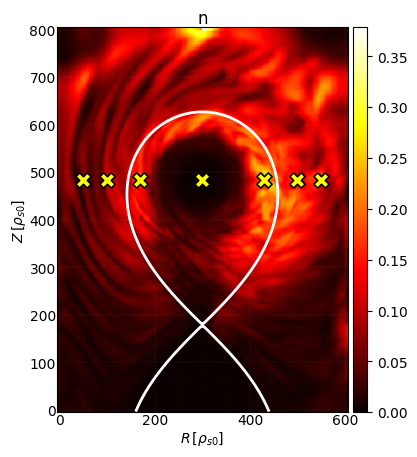

In [26]:
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(4, 5), sharex=True, sharey=True)

cs1 = ax.pcolormesh(X, Y, dens_fluct_avg, cmap='hot')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)


ax.contour(X, Y, Psi, levels=[Psi[s.iyxpt, s.ixxpt]], colors='w', linewidths=2)
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=10, pad=1)
ax.tick_params(axis='y', labelsize=10, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=10, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=10, rotation=90, labelpad=1)

# Several points
ax.scatter(s.x0, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0-130, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0-200, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0-250, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0+130, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0+200, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0+250, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)


ax.set_title(r'n', fontsize=12, pad=1.5)

#plt.gca().set_aspect('equal')
plt.show(block=False)

Using point for density bicoherence: R=548.8, Z=483.8, ix=221, iy=195, iphi=79


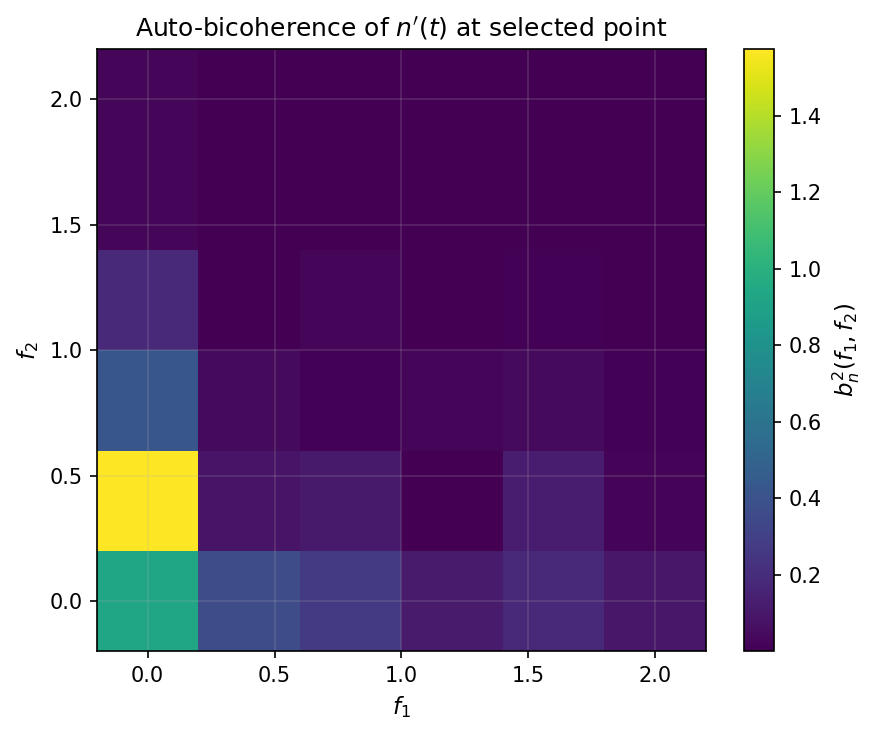

In [38]:
# --------------------------------------------------
# 2) Choose one spatial point (R0,Z0,phi0)
# --------------------------------------------------
#R0 = s.x0   # example LFS point
R0 = s.x0 + 250.0   # example LFS point
Z0 = s.y0

ix0   = np.argmin(np.abs(s.x - R0))
iy0   = np.argmin(np.abs(s.y - Z0))
iphi0 = 79

print(f"Using point for density bicoherence: R={R0:.1f}, Z={Z0:.1f}, ix={ix0}, iy={iy0}, iphi={iphi0}")

# Time series of density fluctuation at that point
ts_n = dens_fluc4D[iy0, ix0, iphi0, :]   # (nt,)

# --------------------------------------------------
# 3) Compute bicoherence for density
# --------------------------------------------------
f, b2 = bicoherence_1d(ts_n, dt, nperseg=None)
nf = len(f)

# restrict to low frequencies for plotting
imax   = nf // 2
f_plot = f[:imax]
b2_plot = b2[:imax, :imax]

F1, F2 = np.meshgrid(f_plot, f_plot)

# --------------------------------------------------
# 4) Plot: auto-bicoherence of density
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
im = ax.pcolormesh(F1, F2, b2_plot, shading='auto', cmap='viridis')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$b_n^2(f_1,f_2)$', fontsize=11)

ax.set_xlabel(r'$f_1$', fontsize=11)
ax.set_ylabel(r'$f_2$', fontsize=11)
ax.set_title(r'Auto-bicoherence of $n^{\prime}(t)$ at selected point', fontsize=12)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


Using point for potential bicoherence: R=548.8, Z=483.8, ix=221, iy=195, iphi=0


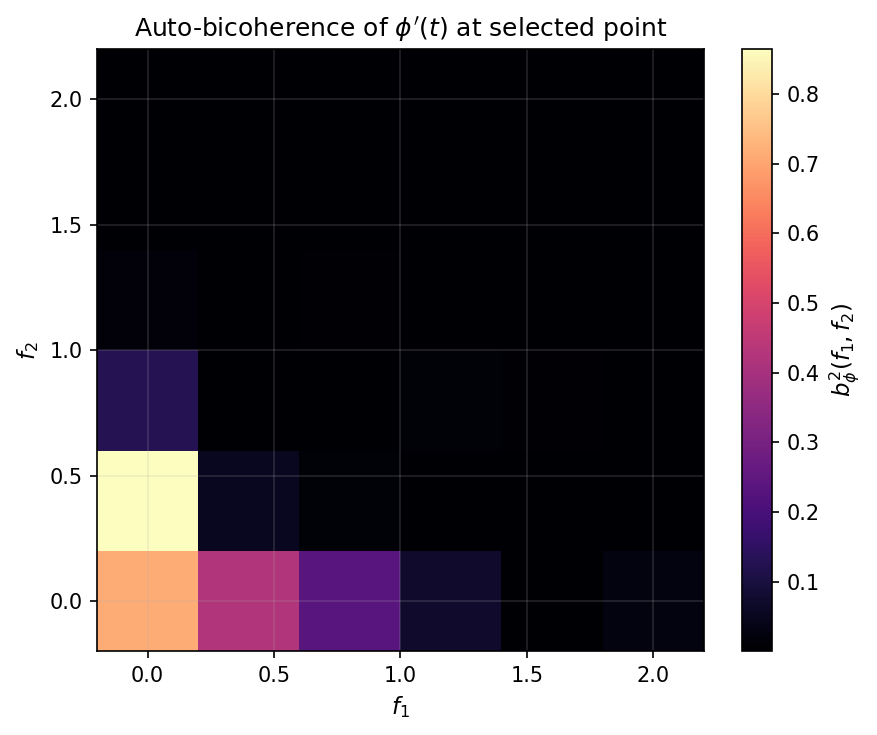

In [34]:
# --------------------------------------------------
# 1) Reuse same point (R0,Z0,iphi0) and dt
# --------------------------------------------------
print(f"Using point for potential bicoherence: R={R0:.1f}, Z={Z0:.1f}, ix={ix0}, iy={iy0}, iphi={iphi0}")

# Time series of potential fluctuation at that point
ts_phi = strmf_fluc4D[iy0, ix0, iphi0, :]   # (nt,)

# --------------------------------------------------
# 2) Compute bicoherence for potential
# --------------------------------------------------
f_phi, b2_phi = bicoherence_1d(ts_phi, dt, nperseg=None)
nf_phi = len(f_phi)

imax_phi   = nf_phi // 2
f_plot_phi = f_phi[:imax_phi]
b2_plot_phi = b2_phi[:imax_phi, :imax_phi]

F1_phi, F2_phi = np.meshgrid(f_plot_phi, f_plot_phi)

# --------------------------------------------------
# 3) Plot: auto-bicoherence of potential
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
im = ax.pcolormesh(F1_phi, F2_phi, b2_plot_phi, shading='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$b_\phi^2(f_1,f_2)$', fontsize=11)

ax.set_xlabel(r'$f_1$', fontsize=11)
ax.set_ylabel(r'$f_2$', fontsize=11)
ax.set_title(r'Auto-bicoherence of $\phi^{\prime}(t)$ at selected point', fontsize=12)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()
